# Assignment Accomplishment:

## ✅ Improved prediction performance: accuracy from .48 on class to .52
### choose at least 3 approaches from the below mentioned suggestions:
 - ✅ data Preparation 
- ✅drop the Japanese comments
- ✅concatenate the 'reviews_text' column with the 'reviews_title' column
- ✅check for punctions
- ✅try to check spelling but cost too much time
- ✅verify the longitude/latitude coordinate with value of city,province,country 

 - ✅ resample by not changing reviews rating proportion
 
 - ✅ increase the dataset - resampling to 6920 rows，4187 remain after geographic validation
 
 - ✅ different tokenization approaches (use count tokenization instead of tfidf)
 
 - ✅ try different machine learning algorithms 
- ✅Support Vector Machine - revised
- ✅Bernoulli Naive Bayes
- ✅Logistic Regression
- ✅Random Forest
- ✅Neural Network

 - ✅ tune the machine learning algorithm that you use (i.e. grid search)
 - ❓feature selection - try to limit the max and min frequency of a feature and limit the total count of features
 - manipulation: convert the problem to a two-class classification problem (e.g. high rate / low rate)
 - other creative approaches

### ✅ show that there is no evidence of over fitting in results : the score between test and train data are quite close

# 0.Preparation
## Import packages

In [559]:
#basic packages
import pandas as pd
import numpy as np
import itertools
import os

#packages for text processing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk import pos_tag
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from enchant.checker import SpellChecker
import string
from textblob import TextBlob

#packages for data mining
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold, learning_curve
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest
#packages for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

# improving table display
from IPython.display import display
init_notebook_mode()
# hide warnings
import warnings
warnings.simplefilter("ignore")

## a dictionary to be used later

In [368]:
#dictionary mapping US state to abbreviations
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

# 1. Reading Data

In [369]:
reviews = pd.read_csv("hotel_review.csv",encoding="UTF-8")
reviews=reviews[['address', 'categories', 'city','province','country','postalCode',
                 'latitude', 'longitude', 'name', 'reviews.date', 
                 'reviews.dateAdded','reviews.doRecommend', 'reviews.id', 
                 'reviews.rating','reviews.text','reviews.title','reviews.username', 
                 'reviews.userCity', 'reviews.userProvince']]
print(reviews.shape)
print(reviews.columns.values.tolist())

(35912, 19)
['address', 'categories', 'city', 'province', 'country', 'postalCode', 'latitude', 'longitude', 'name', 'reviews.date', 'reviews.dateAdded', 'reviews.doRecommend', 'reviews.id', 'reviews.rating', 'reviews.text', 'reviews.title', 'reviews.username', 'reviews.userCity', 'reviews.userProvince']


In [370]:
# adjust column sequence
reviews.columns=['address', 'categories', 'city', 'province', 'country', 'postalCode',
                 'latitude','longitude', 'name',  'reviews_date',
                 'reviews_dateAdded', 'reviews_doRecommend', 'reviews_id',
                 'reviews_rating', 'reviews_text', 'reviews_title','reviews_username',
                 'reviews_userCity', 'reviews_userProvince']

# 2. Data preprocessing

In [371]:
reviews.dtypes

address                  object
categories               object
city                     object
province                 object
country                  object
postalCode               object
latitude                float64
longitude               float64
name                     object
reviews_date             object
reviews_dateAdded        object
reviews_doRecommend     float64
reviews_id              float64
reviews_rating          float64
reviews_text             object
reviews_title            object
reviews_username         object
reviews_userCity         object
reviews_userProvince     object
dtype: object

## Object Columns

In [372]:
reviews.describe(include=[np.object]).iloc[:2,:]

address categories   city province country postalCode   name  \
count    35912      35912  35912    35912   35912      35857  35912   
unique     999        396    761      287       1        911    879   

       reviews_date reviews_dateAdded reviews_text reviews_title  \
count         35653             35912        35890         34290   
unique         3009              1029        34397         21961   

       reviews_username reviews_userCity reviews_userProvince  
count             35869            16263                17518  
unique            15492             2897                  648

In [373]:
reviews_obj = reviews.select_dtypes(['object'])
reviews[reviews_obj.columns] = reviews_obj.apply(lambda x: x.str.strip())
reviews=reviews[reviews['reviews_text'].notna()|reviews['reviews_title'].notna()]
reviews.shape

(35893, 19)

### Create new column to combine text and title together

In [374]:
reviews['reviews_text_combo']=reviews.reviews_title.astype(str)+" "+reviews.reviews_text.astype(str)

### Try to remove stopword, none-english word and punctions  
##### check spelling is time-inefficienct, commented

In [376]:
eng_word = set(nltk.corpus.words.words())
def remover(row):
    # remove punction
    phrase = row['reviews_text_combo'].lower().replace('[^\w\s]','')
    
    phrase_tokenize = word_tokenize(phrase)    
    phrase_clean=" ".join(
                        #str(TextBlob(w).correct()) \
                          w for w in phrase_tokenize if \
                          (w in eng_word) and \
                          (not w in stopwords.words('english')) and \
                         (w.isalpha()))    
#     print("cleaned: ",phrase_clean)    
    return phrase_clean 
reviews['reviews_text_combo']=reviews.apply(lambda row: remover(row), axis='columns', result_type='expand')

In [377]:
reviews=reviews[reviews['reviews_text_combo'].notna()].drop(columns=['reviews_title','reviews_text'])
reviews.shape

(35893, 18)

## Numeric Columns

In [378]:
reviews.describe(include=[np.number]).iloc[:2,:]

latitude     longitude  reviews_doRecommend  reviews_id  \
count  35807.00000  35807.000000                  0.0         0.0   
mean      37.28325    -85.735312                  NaN         NaN   

       reviews_rating  
count    35031.000000  
mean         3.776509

### drop columns with all null values and rows with inapplicable geographic values

In [379]:
reviews=reviews.drop(columns=['reviews_doRecommend','reviews_id'])

In [380]:
reviews = reviews[reviews['longitude'].notna()&reviews['latitude'].notna()&reviews['reviews_rating'].notna()]
reviews.shape

(34955, 16)

### change datatypes and filter by values

In [381]:
#choose only applicable ratings
reviews = reviews[reviews['reviews_rating']<=5]
#rounding the reviews' rating
reviews.reviews_rating = reviews.reviews_rating.astype(int)
reviews.longitude = reviews.longitude.round(6)
reviews.latitude = reviews.latitude.round(6)
reviews.shape

(34598, 16)

In [382]:
reviews.dtypes

address                  object
categories               object
city                     object
province                 object
country                  object
postalCode               object
latitude                float64
longitude               float64
name                     object
reviews_date             object
reviews_dateAdded        object
reviews_rating            int64
reviews_username         object
reviews_userCity         object
reviews_userProvince     object
reviews_text_combo       object
dtype: object

## Resampling before validating geographic coordinates to accelerate processing time

In [388]:
from sklearn.model_selection import train_test_split
y=reviews['reviews_rating']
X=reviews.drop(columns="reviews_rating")
X_remain, X_sel, y_remain, y_sel = train_test_split(X, y, test_size=0.2, random_state=6)

In [397]:
X_sel['reviews_rating']=y_sel
rev_sel=X_sel
rev_sel.shape

(6920, 16)

### validate geographic coordinates to province and city - takes great great long time

In [398]:
import reverse_geocoder as rg 
rev_sel["validation"]=0
def geoValidate(row):
    country=rg.search((row[6],row[7]))[0]["cc"]
    # all data in country column is 'US'
    if country!='US':
        return [row[3],-1]
    
    else:
        province=us_state_abbrev[rg.search((row[6],row[7]))[0]["admin1"]] # lng/lat province abbrev
        province1=rg.search((row[6],row[7]))[0]["admin1"] # lng/lat province full 
        city=rg.search((row[6],row[7]))[0]["name"] # lng/lat city
###################################################################################       
#         if (row[2].lower()==city.lower()) and (row[3].lower()==province.lower() or row[3].lower()==province1.lower()):
#             return [province,1]
########### can be too slow adding this check,commented for efficiency#############    
        if (row[2].lower()==city.lower()):
            return [province,1]
        else:
            return [row[3],-1]

In [399]:
rev_sel[["province","validation"]]=rev_sel.apply(lambda row: geoValidate(row), axis='columns', result_type='expand')

In [400]:
rev_sel1=rev_sel[rev_sel['validation']>0]
rev_sel1.shape

(4187, 17)

# 3. Visualization
### Heatmap of average review rating by State

In [401]:
import chart_studio.plotly as py
import plotly.io as pio

df_cnt= rev_sel1.groupby("province")['reviews_rating'] \
        .agg([("record_cnt","size"),("avg_reviews_rating","mean")]) \
        .reset_index()

df_frequent=rev_sel1.groupby(["province"])['name'].agg(pd.Series.mode).to_frame().rename(columns={"name":"frequent_name"}).reset_index()

df=df_cnt.join(df_frequent.set_index('province'),on='province')

inv_map = {v: k for k, v in us_state_abbrev.items()}
df['province_full']=df['province'].map(inv_map)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]
for col in df.columns:
    df[col]=df[col].astype(str)
df['text'] = df['province']+"("+df['province_full']+")"+'<br>'+\
            'record count: '+df['record_cnt']+'<br>'+\
            'most popular hotel: '+df['frequent_name']

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df['province'],
        z = df['avg_reviews_rating'].astype(float).round(2),
        locationmode = 'USA-states',
        text = df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = "avg reviews rating"
        )
    ) ]

layout = dict(
        title = 'Average Hotel Reviews Rating by State',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = dict( data=data, layout=layout)

url = pio.show( fig, filename='d3-cloropleth-map' )

### Word cloud of review text

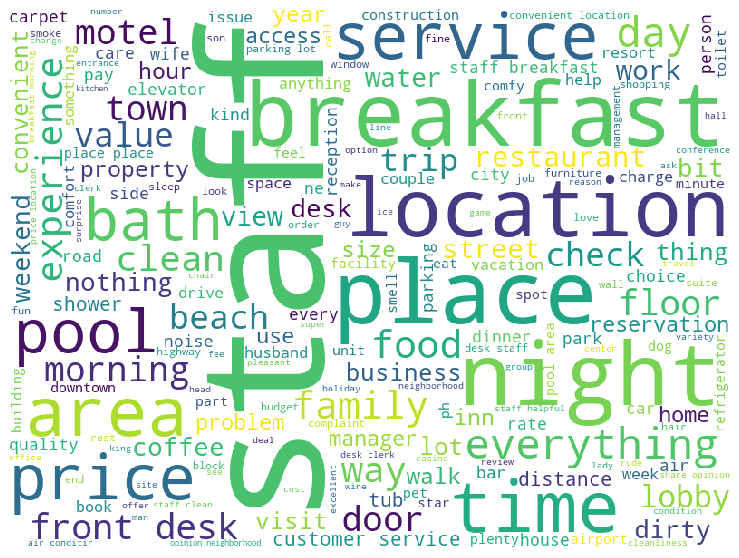

In [505]:
stopwords = set(STOPWORDS)
def cloud(data,backgroundcolor = 'white', width = 800, height = 600):
    wordcloud = WordCloud(stopwords = STOPWORDS, background_color = backgroundcolor,
                         width = width, height = height).generate(data)
    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
def get_noun(row):
    if row!=" " and len(row)>0:
        return " ".join([word for word,pos in pos_tag(row.split(" ")) if pos == 'NN'])
    else:
        return None
l = ["nice","room","hotel", "stay", "good", "well", "one","great","ed"]
review_text_col1=rev_sel1['reviews_text_combo'].apply(lambda row: get_noun(row)).str.replace("|".join(l),"")
review_text_col1=review_text_col1[review_text_col1.notna()]
cloud(' '.join(review_text_col1))

# 4. Modelling
### split the data by train and test

In [734]:
l1=["room","hotel","cross","united"]
X=rev_sel1['reviews_text_combo'].apply(lambda row: row.replace("|".join(l1),""))
y=rev_sel1['reviews_rating']
seed=3
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

### tokenize with count tokenization instead of tfidf

In [736]:
#Creating a vectorizer to split the text into unigrams and bigrams
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = "word", 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = 'english', 
                             max_features = 50000,
                             max_df=0.9999,
                             min_df=0.0001,
                             ngram_range = (1,2)
                            )

train_x = vectorizer.fit_transform(x_train)

# only call transform not fit_transform to avoid overfitting.
test_x = vectorizer.transform(x_test)
print('train dim:', train_x.shape, 'test dim:', test_x.shape)

train dim: (3349, 44223) test dim: (838, 44223)


## Different Machine Learning Techniques

In [737]:
from sklearn.svm import LinearSVC
# Linear SVC in class: 0.48
classf = LinearSVC()
classf.fit(train_x, y_train)
pred = classf.predict(test_x)
print("Linear SVC:",accuracy_score(y_test, pred))

Linear SVC: 0.48568019093078757


In [738]:
kfold = StratifiedKFold(n_splits = 10, random_state = seed)

## Support Vector Machine - GridSearch 

In [739]:
sv = LinearSVC(random_state=seed)

param_grid_sv = {
    'loss':['hinge'],
    'C': [0.01,0.05,0.08,0.1,0.11,0.2,0.5,1]
}

gs_sv = GridSearchCV(sv, param_grid = [param_grid_sv], verbose = 0, cv = kfold, n_jobs = -1, scoring = 'accuracy' )
gs_sv.fit(train_x, y_train)

print("Best estimator:\n",gs_sv.best_estimator_)
print("Linear SVC-improved train score:",round(gs_sv.best_score_,2))
pred_sv = gs_sv.predict(test_x)
print("Linear SVC-improved test score:",round(accuracy_score(y_test, pred_sv),2))

Best estimator:
 LinearSVC(C=0.08, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
          penalty='l2', random_state=3, tol=0.0001, verbose=0)
Linear SVC-improved train score: 0.49
Linear SVC-improved test score: 0.51


## Bernoulli Naive Bayes 

In [740]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
param_grid_bnb = {
    'alpha': [0.01,0.03,0.05,0.1,0.2,1],
    'binarize': [0,0.001,0.01,0.1,1]
}
gs_bnb = GridSearchCV(bnb, param_grid =param_grid_bnb , verbose = 0, cv = kfold, n_jobs = -1, scoring = 'accuracy')
gs_bnb.fit(train_x, y_train)

print("Best estimator:\n",gs_bnb.best_estimator_)
print("Bernoulli Naive Bayes train score:",round(gs_bnb.best_score_,2))
pred_bnb = gs_bnb.predict(test_x)
print("Bernoulli Naive Bayes test score:",round(accuracy_score(y_test, pred_bnb),2))

Best estimator:
 BernoulliNB(alpha=0.2, binarize=0, class_prior=None, fit_prior=True)
Bernoulli Naive Bayes train score: 0.45
Bernoulli Naive Bayes test score: 0.47


## Logistic Regression

In [741]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state = seed)
param_grid_lr = {
    'penalty':['l2','l1'],
    'tol':[0.001,0.01,0.1,0.5,1],
    'C':[0.001,0.01,0.1,0.5,1],
    'max_iter':[1000]
}

gs_lr = GridSearchCV(lr, param_grid =param_grid_lr , verbose = 0, cv = kfold, n_jobs = -1, scoring = 'accuracy')
gs_lr.fit(train_x, y_train)

print("Best estimator:\n",gs_lr.best_estimator_)
print("Logistic Regression train score:",round(gs_lr.best_score_,2))
pred_lr = gs_lr.predict(test_x)
print("Logistic Regression test score:",round(accuracy_score(y_test, pred_lr),2))

Best estimator:
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=3, solver='warn', tol=0.5, verbose=0,
                   warm_start=False)
Logistic Regression train score: 0.5
Logistic Regression test score: 0.52


## Random Forest

In [742]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=seed)
param_grid_rf = {
    'n_estimators':[50,100,200],
    'max_depth':[5,10],
    'min_samples_split':[4,10,20]
}

gs_rf = GridSearchCV(rf, param_grid =param_grid_rf , verbose = 0, cv = kfold, n_jobs = -1, scoring = 'accuracy')
gs_rf.fit(train_x, y_train)

print("Best estimator:\n",gs_rf.best_estimator_)
print("Random Forest train score:",round(gs_rf.best_score_,2))
pred_rf = gs_rf.predict(test_x)
print("Random Forest test score:",round(accuracy_score(y_test, pred_rf),2))

Best estimator:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)
Random Forest train score: 0.37
Random Forest test score: 0.38


## Neural Network

In [606]:
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(random_state = seed)
param_grid_mlp = {
    'hidden_layer_sizes':[(10,),(50,),(100,)],
    'activation':['logistic','relu'],
    'solver':['sgd'],
    'alpha':[0.001,0.01,0.1],
    'learning_rate':['constant','adaptive'],
    'max_iter':[1000],
    'early_stopping':[True]
}
gs_mlp = GridSearchCV(MLP, param_grid =param_grid_mlp , verbose = 0, cv = kfold, n_jobs = -1, scoring = 'accuracy')
gs_mlp.fit(train_x, y_train)

print("Best estimator:\n",gs_mlp.best_estimator_)
print("Neural Network train score:",round(gs_mlp.best_score_,2))
pred_mlp = gs_mlp.predict(test_x)
print("Neural Network test score:",round(accuracy_score(y_test, pred_mlp),2))

Best estimator:
 MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(50,), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=66, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)
Neural Network train score: 0.42
Neural Network test score: 0.42


# 5. Results
## Confusion Matrix

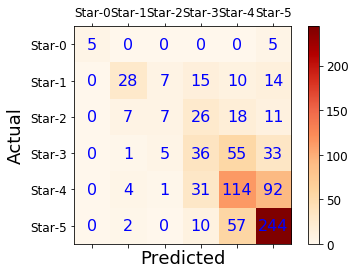

In [743]:
confusion_mtx = confusion_matrix(y_true=y_test, y_pred=pred_lr)
# print('Confusion matrix:\n', confusion_mtx)

labels = ['star-0', 'star-1', 'star-2', 'star-3', 'star-4', 'star-5']

plt.rcParams.update({'font.size': 12})
COLOR = 'blue'
plt.rcParams['text.color'] = COLOR
fig, ax = plt.subplots()

min_val, max_val = 0, 6

labels = ['Star-0', 'Star-1', 'Star-2', 'Star-3', 'Star-4', 'Star-5']

ax.matshow(confusion_mtx, cmap="OrRd")
cax = ax.matshow(confusion_mtx, cmap="OrRd")

fig.colorbar(cax)

ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)

plt.xlabel('Predicted', fontsize=18,labelpad =5)
plt.ylabel('Actual', fontsize=18,labelpad =5)
plt.rcParams.update({'font.size': 16})

for i in range(6):
    for j in range(6):
        c = confusion_mtx[j,i]
        ax.text(i, j, str(c), va='center', ha='center')

## highlight the important features 
### get the best model from LinearSVC

In [745]:
classf = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=3, solver='warn', tol=0.5, verbose=0,
                   warm_start=False)

classf.fit(train_x, y_train)
pred = classf.predict(test_x)
print("Logistic Regression:",accuracy_score(y_test, pred))

Logistic Regression: 0.5178997613365155


################################# 0 STAR REVIEW #################################


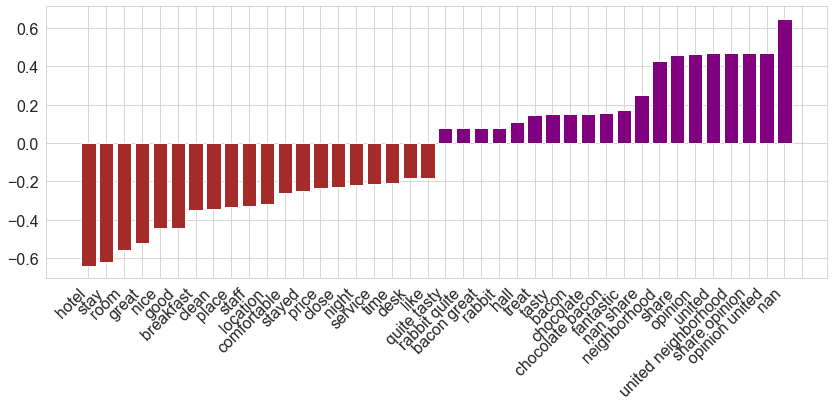

################################# 1 STAR REVIEW #################################


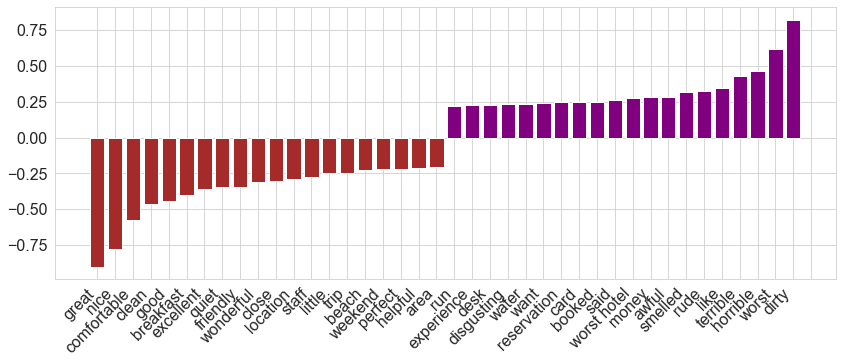

################################# 2 STAR REVIEW #################################


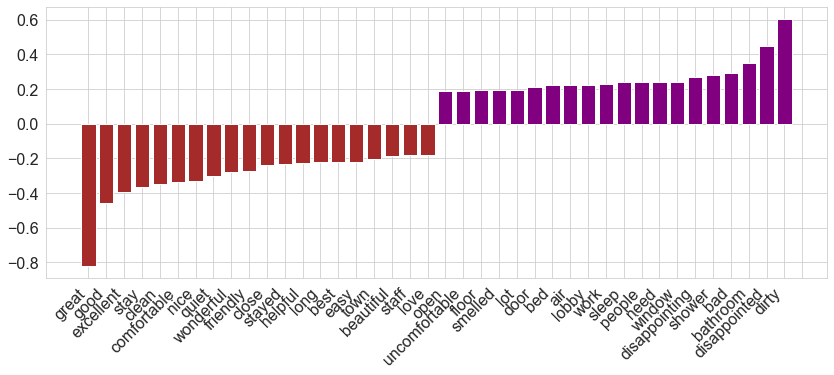

################################# 3 STAR REVIEW #################################


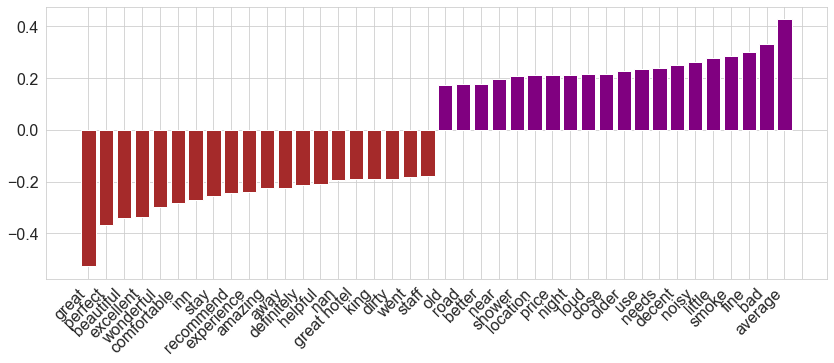

################################# 4 STAR REVIEW #################################


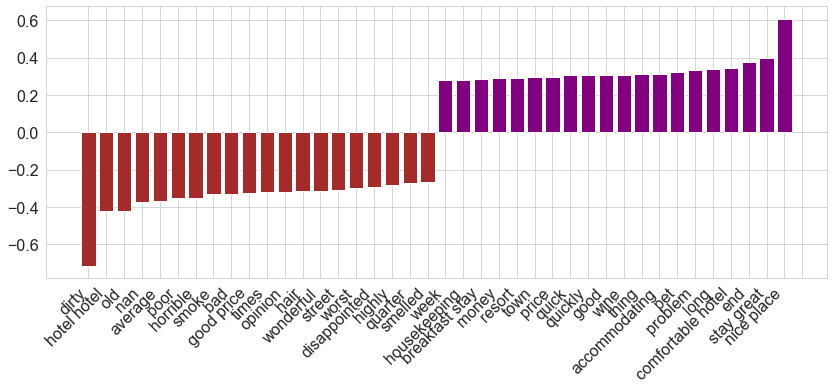

################################# 5 STAR REVIEW #################################


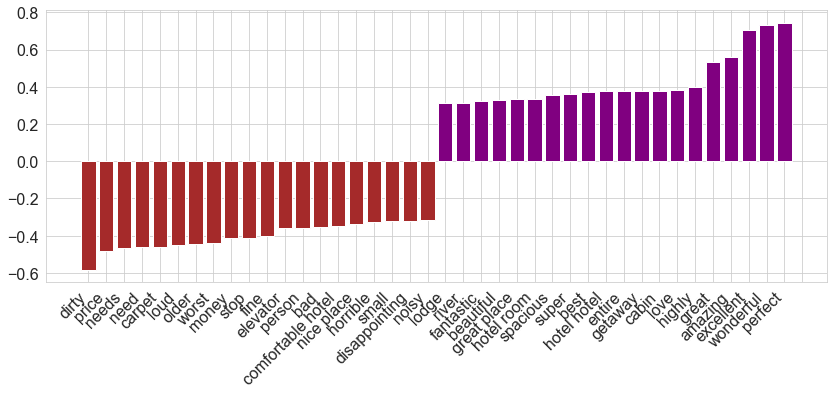

In [762]:
def plot_coef_class(model_in, feat_name, top_feat=20):
    # extract the coefficients from model
    coef = model_in.coef_
    
    # extract the classes (categories) from model
    categories = model_in.classes_
    
    # finding the top features in each class by iterating over it
    for i in range(len(categories)):
        print("#################################",categories[i],"STAR REVIEW #################################")

        # Access the coeeficients assoxiated to each categories
        cat_coef = coef[i]

        
        # finding top positive and negative coefficients 
        top_positive = np.argsort(cat_coef)[-top_feat:]
        top_negative = np.argsort(cat_coef)[:top_feat]

        # Concatenating both positive and negative coefficients
        top_both = np.hstack([top_negative, 
                                      top_positive])
        # make an empty plot object
        plt.figure(figsize=(14, 5))

        colors = ["brown" if c < 0 else "purple" for c in cat_coef[top_both]]
        plt.bar(np.arange(2 * top_feat), cat_coef[top_both], color=colors)
        feat_name = np.array(feat_name)

        # setting the label parameters
        plt.xticks(np.arange(0, 1 + 2 * top_feat), 
                   feat_name[top_both], rotation=45, ha="right")
        plt.show()
plot_coef_class(classf, vectorizer.get_feature_names())

### A positive value on a feature means that it increases the chances of the class, in comparison with the other classes. Similarly, a negative value on a feature decreases the chances of the class.

## suggestions for improving ratings of the hotels!!

In [758]:
from textblob import TextBlob

tmp_desc = list()

column_convert=rev_sel1['reviews_text_combo'].astype(str)

for row in column_convert:
    blob = TextBlob(row)
    tmp_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    results = pd.DataFrame(tmp_desc, columns = ['sentence','sentiment','polarity'])

def func(results):
    if results['sentiment'] > 0:
        val = "Positive"
    elif results['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

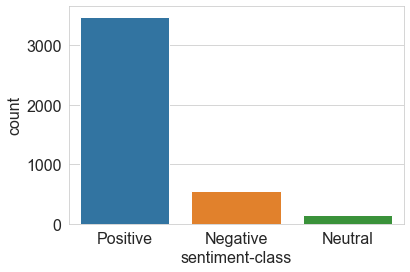

In [763]:
res_sentiment=results.apply(func, axis=1).to_frame(name="sentiment-class")
sns.set_style('whitegrid')
sns.countplot(x='sentiment-class',data=res_sentiment)

In [761]:
results

sentence  sentiment  polarity
0     gorgeous funky totally divine great everything...   0.330357  0.671429
1     everything need unless plan spending ton time ...   0.556667  0.743333
2     perfect hotel location attend football game ho...   0.337245  0.637245
3     convenient clean great location modest price e...   0.500000  0.829167
4     nice efficiency apartment full kitchen motel w...   0.300000  0.470833
5     great value great location five ten minute wal...   0.407292  0.683333
6                    comfortable stay manager nice help   0.500000  0.900000
7     motorcycle friendly stayed another couple trav...   0.288333  0.485000
8     good location great place stay friendly room c...   0.560417  0.637500
9     avoid current condition hotel old might sectio...   0.162500  0.295833
10    five great motel every detail taken care room ...   0.368750  0.575000
11    nan hierarchy hotelier chip de hotel chain bas...   0.266270  0.451984
12    good hotel stay hotel good experience entourag...   0.379167  0.504167
13    nan motel easy find easy access came visit wes...   0.098389  0.475210
14    first last time air unit extremely loud filthy...  -0.190000  0.640000
15                                     walk ocean hotel   0.000000  0.000000
16    relaxation went away regroup pool hot tub beau...   0.488889  0.850000
17    patina bygone age wireless cutting get use nea...  -0.600000  0.900000
18    great stay stayed beach like one came shamrock...   0.332589  0.587798
19                     fireside inn great place awesome   0.900000  0.875000
20    recommend hotel stayed overnight quiet hotel n...   0.309524  0.576190
21    college visit pleasure visiting daughter lake ...   0.475000  0.786667
22    clean room courteous staff noise bad stayed mi...   0.240530  0.740152
23    good value awful room smelled funny bathtub fl...  -0.230000  0.740000
24                            nice place good nice pool   0.633333  0.866667
25    hotel close tech stayed days experience stayed...  -0.100000  0.411111
26    standard spent weekend nice bathroom clean ele...   0.216667  0.450000
27    nice hotel price least need add basic need cus...   0.100000  0.508333
28    quiet stayed large baseball tournament lot aro...   0.207738  0.448810
29    good place rest head good place stay train sto...   0.304464  0.460714
...                                                 ...        ...       ...
4157  stop stop way hotel clean comfortable staff fr...   0.380556  0.666667
4158  b wonderful hotel amazingly clean older beach ...   0.623611  0.598611
4159  count breakfast hotel bit could use carpet roo...   0.461667  0.775000
4160  nice hotel nice hotel interesting interior roo...   0.362500  0.725000
4161  night good location interstate comfortable scr...   0.488889  0.700000
4162  quiet clean despite age good stopover night es...   0.154167  0.675000
4163                                                nan   0.000000  0.000000
4164  b b close everything great location comfortabl...   0.587500  0.737500
4165  beautiful hotel heart old town typical brick e...   0.148244  0.521212
4166  nice location old town awesome place historic ...   0.344444  0.538889
4167  great downtown location stay great thing like ...   0.800000  0.750000
4168  shopping get away front desk always helpful al...   0.700000  0.600000
4169  night spent one night late bed night place pur...  -0.044167  0.446667
4170            good hotel everything breakfast missing   0.250000  0.325000
4171            nan suppost quality inn told change got   0.000000  0.000000
4172  good place stay stayed one night good place st...   0.375379  0.581818
4173  one best hotel ever trip last minute one admit...   0.362500  0.304167
4174  bad price stayed wedding weekend easily access...   0.237963  0.515741
4175  clean comfortable hotel clean comfortable prof...   0.142424  0.445455
4176                   kind old still cheap comfortable   0.375000  0.650000
4177  good place go great stay conference a